In [2]:
# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!pip install torchbnn

In [4]:
# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr
import torchbnn as bnn
from scipy import stats

In [5]:
#import dataset
fatigue_df = pd.read_csv('../Data/Titanium_Alloy_UC.csv', encoding='latin1')
fatigue_df

,SL. Number,Number of Cycles,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,...,C,N,O,H,Fe,Si,Sn,Nb,Mo,Zr
0,123,100000,860.00,932,0.0,25,704,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0
1,126,100000,850.00,925,1.0,25,700,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0
2,158,1000000,800.00,932,0.0,25,704,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0
3,161,1000000,780.00,925,1.0,25,700,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0
4,164,1000000,699.00,0,0.0,25,700,2.0,0.0,0.5,...,0.00,0.0130,0.19,0.0041,0.19,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,18,249,915.24,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
216,27,325,910.82,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
217,31,370,907.55,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
218,41,444,900.00,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7


In [6]:
fatigue_df.info()

# Sort the data by ascending order of number of cycles
fatigue_df.sort_values(by=['Number of Cycles'], ascending=True, ignore_index=True, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   SL. Number                    220 non-null    int64  
 1   Number of Cycles              220 non-null    int64  
 2   Stress (MPa)                  220 non-null    float64
 3   Solution Temperature (°C)     220 non-null    int64  
 4   Solution Time (hrs)           220 non-null    float64
 5   Temperature Measurement (°C)  220 non-null    int64  
 6   Ann/Age. temp (cel)           220 non-null    int64  
 7   Ann/age time (hrs)            220 non-null    float64
 8   Total Strain (%)              220 non-null    float64
 9   R                             220 non-null    float64
 10  Frequency (Hz)                220 non-null    float64
 11  Ti                            220 non-null    float64
 12  Al                            220 non-null    float64
 13  V    

<Axes: >

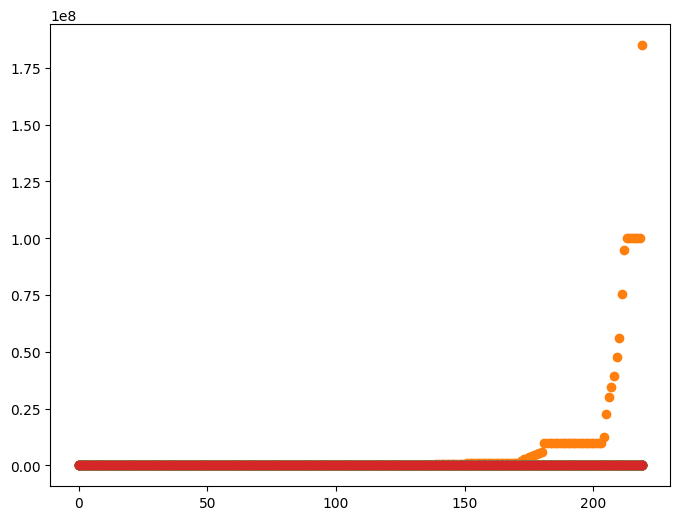

In [7]:
# Scatter Plot of Target Column
fatigue_df.plot(style = 'o', figsize=(8, 6), legend = False)

In [8]:
# Remove columns that are not needed
drop_cols = ['Number of Cycles','SL. Number'] # list the columns to drop along with target for independent feautures

# Use all remaining columns as features
features = fatigue_df.drop(drop_cols, axis=1)

# Use log transform of the number of cycles as targets
targets = np.log10(fatigue_df['Number of Cycles'])

# Display the features
features

,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,Frequency (Hz),Ti,...,C,N,O,H,Fe,Si,Sn,Nb,Mo,Zr
0,1067.63,1020,1.0,25,700,2.0,1.25,-1.0,0.2,84.90,...,0.050,0.0025,0.000,0.004,0.00,0.340,4.00,0.70,0.500,3.70
1,685.38,1025,2.0,450,1025,2.0,1.00,0.0,0.0,85.01,...,0.065,0.0020,0.090,0.000,0.00,0.305,4.02,0.71,0.505,3.54
2,700.06,1025,2.0,400,1025,2.0,1.00,0.0,0.0,85.01,...,0.065,0.0020,0.090,0.000,0.00,0.305,4.02,0.71,0.505,3.54
3,711.56,1025,2.0,425,1025,2.0,1.00,0.0,0.0,85.01,...,0.065,0.0020,0.090,0.000,0.00,0.305,4.02,0.71,0.505,3.54
4,649.41,1025,2.0,500,1025,2.0,1.00,0.0,0.0,85.01,...,0.065,0.0020,0.090,0.000,0.00,0.305,4.02,0.71,0.505,3.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,293.94,0,0.0,750,1300,4.0,0.00,0.0,20.0,52.39,...,0.016,0.5300,0.002,0.023,0.00,0.000,0.00,18.70,0.000,0.00
216,282.17,0,0.0,600,1300,4.0,0.00,0.0,20.0,52.39,...,0.016,0.5300,0.002,0.023,0.00,0.000,0.00,18.70,0.000,0.00
217,253.59,0,0.0,25,1300,4.0,0.00,0.0,20.0,52.39,...,0.016,0.5300,0.002,0.023,0.00,0.000,0.00,18.70,0.000,0.00
218,180.72,0,0.0,400,1300,4.0,0.00,0.0,20.0,52.39,...,0.016,0.5300,0.002,0.023,0.00,0.000,0.00,18.70,0.000,0.00


In [9]:
features.head()

,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,Frequency (Hz),Ti,...,C,N,O,H,Fe,Si,Sn,Nb,Mo,Zr
0,1067.63,1020,1.0,25,700,2.0,1.25,-1.0,0.2,84.90,...,0.050,0.0025,0.00,0.004,0.0,0.340,4.00,0.70,0.500,3.70
1,685.38,1025,2.0,450,1025,2.0,1.00,0.0,0.0,85.01,...,0.065,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54
2,700.06,1025,2.0,400,1025,2.0,1.00,0.0,0.0,85.01,...,0.065,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54
3,711.56,1025,2.0,425,1025,2.0,1.00,0.0,0.0,85.01,...,0.065,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54
4,649.41,1025,2.0,500,1025,2.0,1.00,0.0,0.0,85.01,...,0.065,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54


In [10]:
features = features.reset_index(drop=True)

Run # 1 Fold # 1
MSE : 20.22, KL : 0.63
MSE : 0.46, KL : 0.92
MSE : 0.23, KL : 1.02
Pearson CC: 0.9397393341224699
R2 score: 0.8794512748718262
RMSE: 0.6882646679878235
MAE: 0.4992622137069702
********************
Coverage: 47.72727272727273
Interval Width: 1.0590806007385254
Composite Metric: 0.5940083451612612


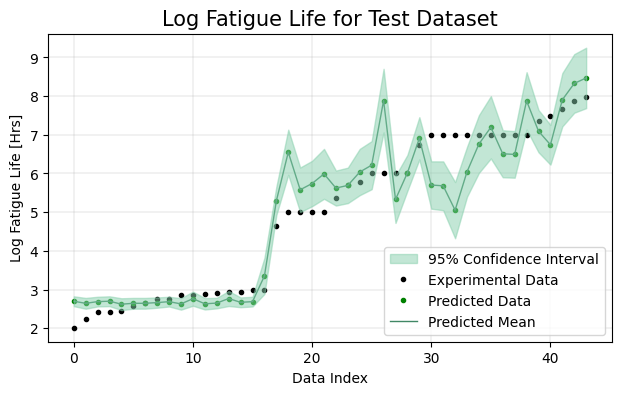

****************************************
Run # 1 Fold # 2
MSE : 16.83, KL : 0.63
MSE : 0.33, KL : 0.93
MSE : 0.33, KL : 1.03
Pearson CC: 0.937913585970343
R2 score: 0.8662323951721191
RMSE: 0.6683431267738342
MAE: 0.4395847022533417
********************
Coverage: 38.63636363636364
Interval Width: 0.7888154983520508
Composite Metric: 0.606703619886128


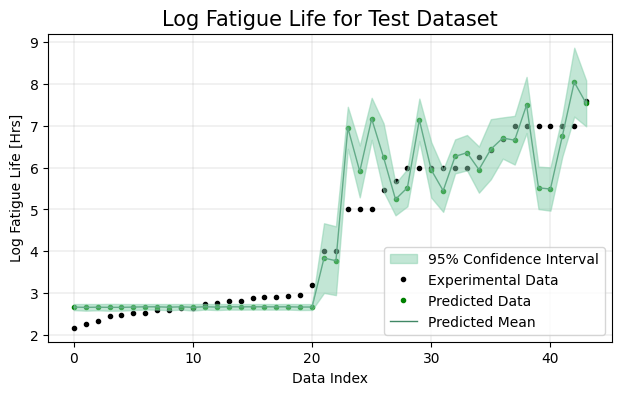

****************************************
Run # 1 Fold # 3
MSE : 20.10, KL : 0.63
MSE : 0.38, KL : 0.92
MSE : 0.30, KL : 1.02
Pearson CC: 0.9550931996821751
R2 score: 0.9114751219749451
RMSE: 0.546528160572052
MAE: 0.4013502895832062
********************
Coverage: 50.00000000000001
Interval Width: 0.5083298683166504
Composite Metric: 0.8668066310521602


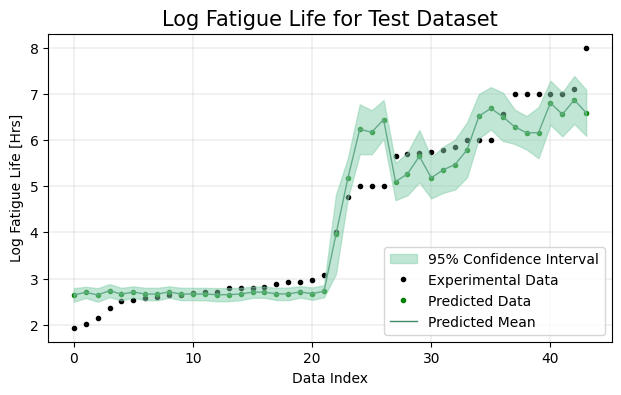

****************************************
Run # 1 Fold # 4
MSE : 22.00, KL : 0.63
MSE : 0.42, KL : 0.91
MSE : 0.44, KL : 1.00
Pearson CC: 0.9312999277186949
R2 score: 0.8615303039550781
RMSE: 0.7062901258468628
MAE: 0.46697962284088135
********************
Coverage: 40.90909090909091
Interval Width: 0.5357611179351807
Composite Metric: 0.7734440559829554


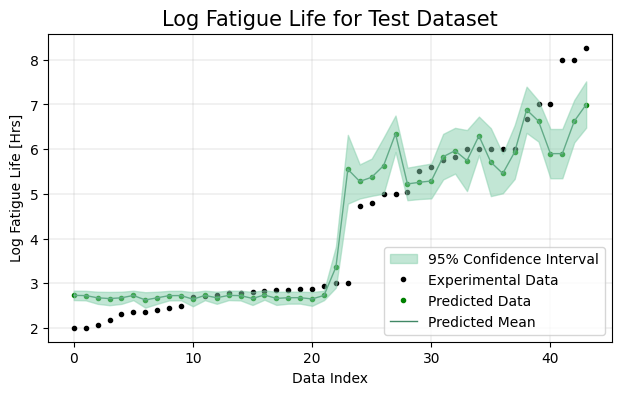

****************************************
Run # 1 Fold # 5
MSE : 20.26, KL : 0.64
MSE : 0.42, KL : 0.92
MSE : 0.31, KL : 1.02
Pearson CC: 0.943441000664173
R2 score: 0.8869779109954834
RMSE: 0.6253881454467773
MAE: 0.4565974175930023
********************
Coverage: 34.09090909090909
Interval Width: 0.668212890625
Composite Metric: 0.6298140797821105


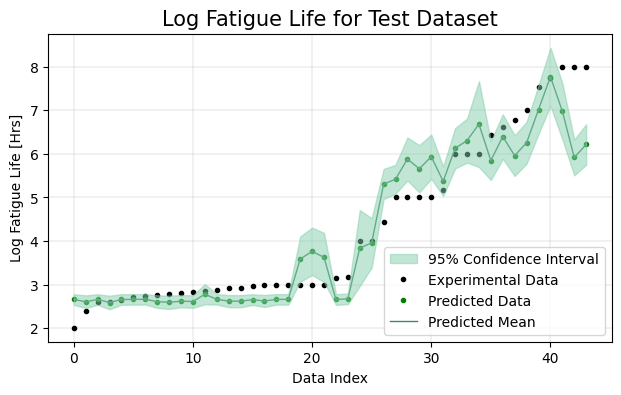

****************************************


In [11]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)


test_coverage = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)
for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)
            targets = targets.reset_index(drop=True)


            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            # normalized features to the [0,1] range
            scaler = MinMaxScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

            x_train = x_train.astype(dtype=np.float32)
            x_test = x_test.astype(np.float32)
            y_train_np = y_train.to_numpy(dtype=np.float32)
            y_test_np =  y_test.to_numpy(dtype=np.float32)

            x_train = torch.from_numpy(x_train)
            y_train = torch.from_numpy(y_train_np)
            y_train = torch.unsqueeze(y_train, dim=1)
            x_test = torch.from_numpy(x_test)
            y_test = torch.from_numpy(y_test_np)
            y_test = torch.unsqueeze(y_test, dim=1)

            # create pytorch dataset class
            class MyDataset(Dataset):
                def __init__(self, train_data, train_targets):
                    self.train_features = train_data
                    self.train_labels = train_targets

                def __len__(self):
                    return self.train_features.shape[0]

                def __getitem__(self, idx):
                    feature = self.train_features[idx]
                    label = self.train_labels[idx]

                    return feature, label

            train_dataset = train_dataset = MyDataset(x_train, y_train)
            train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)
            model = nn.Sequential(
                  bnn.BayesLinear(prior_mu=0, prior_sigma=0.06, in_features=22, out_features=100),
                  nn.ReLU(),
                  bnn.BayesLinear(prior_mu=0, prior_sigma=0.06, in_features=100, out_features=100),
                  nn.ReLU(),
                  bnn.BayesLinear(prior_mu=0, prior_sigma=0.06, in_features=100, out_features=100),
                  nn.ReLU(),
                  bnn.BayesLinear(prior_mu=0, prior_sigma=0.06, in_features=100, out_features=1),
            )

            # define the loss function and optimizer
            mse_loss = nn.MSELoss()
            kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
            kl_weight = 0.01

            optimizer = optim.SGD(model.parameters(), lr=0.001, nesterov=True, momentum=0.95)
            for step in range(3000):
                  for n, data in enumerate(train_dataloader):
                        traning_data, training_label = data
                        y_pred = model(traning_data)
                        mse = mse_loss(y_pred, training_label)
                        kl = kl_loss(model)
                        cost = mse + kl_weight*kl
                        optimizer.zero_grad()
                        cost.backward()
                        optimizer.step()

                  if step % 1000==0:
                        print('MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))
            y_pred_test = model(x_test)

            # inference
            n_samples = 1000

            # compute predictions
            y_preds = [model(x_test).clone().detach().numpy() for _ in range(n_samples)]
            y_preds = np.array(y_preds)
            # mean and standard deviation
            y_pred = np.mean(y_preds, axis=0)
            y_std = np.std(y_preds, axis=0)
            y_test = y_test.detach().numpy()

            ## Metrics for evaluating the predictive accuracy of the model

            PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_pred))[0]
            R2_score[j, i] = r2_score(y_test, y_pred)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred, y_test))
            MAE[j, i] = np.mean(abs(y_pred-np.array(y_test)))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

            print(20*'*')

            ## Metrics for evaluating the uncertainty quantification of the model
            # Coverage
            def coverage(y, yL, yH):
                  return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

            df_test_low = y_pred - 2*y_std
            df_test_mean = y_pred
            df_test_high = y_pred + 2*y_std

            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)

            print(f'Coverage: {test_coverage[j, i]}')


            # Prediction interval width
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            # Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, np.squeeze(y_pred) - 2*np.squeeze(y_std), np.squeeze(y_pred) + 2*np.squeeze(y_std), alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, np.squeeze(y_pred), 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Fatigue Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Fatigue Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')
            fig.delaxes(ax[1])

            plt.show()

            print(40*'*')

In [12]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE
0,0.939739,0.879451,0.688265,0.499262
1,0.937914,0.866232,0.668343,0.439585
2,0.955093,0.911475,0.546528,0.401350
3,0.931300,0.861530,0.706290,0.466980
4,0.943441,0.886978,0.625388,0.456597


In [13]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std
0,0.941497,0.007856,0.881133,0.017686,0.646963,0.056983,0.452755,0.032236


In [14]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(),  'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,47.727273,1.059081,0.594008
1,38.636364,0.788815,0.606704
2,50.000000,0.508330,0.866807
3,40.909091,0.535761,0.773444
4,34.090909,0.668213,0.629814


In [15]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std,
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,42.272727,5.856409,0.71204,0.200412,0.694155,0.107622
